<a href="https://colab.research.google.com/github/samuel0922/my_gd/blob/main/%5BGD_08%5DSEMANTIC_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [GD_08]SEMANTIC_SEGMENTATION

### 개요 ----------------------------------
* U-Net을 통한 세그멘테이션 작업 
* U-Net++ 모델 구현
* U-Net vs. N-Net++

### 목차 ----------------------------------

#### Part I. 노드 구현

* STEP 0. 환경설정 
* STEP 1. 데이터준비
* STEP 2. 모델 구성
* STEP 3. 모델 학습
* STEP 4. 시각화

### Part II. 프로젝트 구현 : 개선된 U-Net 모델

* STEP 0. 환경설정 
* STEP 1. 데이터준비
* STEP 2. 데이터 전처리
* STEP 3. 모델 구성
* STEP 4. 학습 및 평가

* 루브릭
* 회고
* Reference.

---
Part I. 노드 구현
---


## STEP 0. 환경 설정


In [1]:
#필요한 라이브러리를 로드합니다. 

import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *



## STEP 1. 데이터 준비


### S1-1. Augmentation 준비

* Albumentation 사용범
* Compose() : 다양한 augmentation기법을 확률적으로 적용할 수 있게 해줌. => Imgaug의 Sometimes()와 유사한 기능

In [2]:
# Augmentation 함수 정의

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

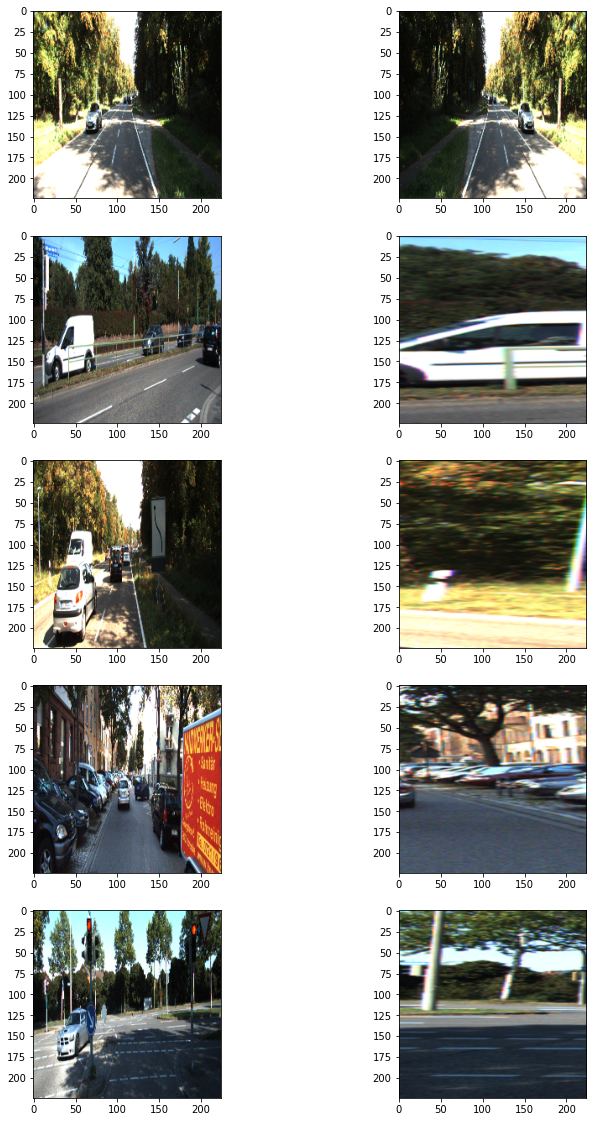

In [3]:
# Augmentation 적용

dir_path = '/content/drive/MyDrive/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

### S1-2. DataLoader 준비

In [4]:
#  KittiGenerator는 tf.keras.utils.Sequence를 상속받음
# 우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용.
   
class KittiGenerator(tf.keras.utils.Sequence):

    def __init__(self,
                 dir_path,  # dataset의 directory path
                 batch_size=4,  
                 img_size=(224, 224, 3),  # 전처리에 사용할 입력이미지 크기
                 output_size=(224, 224),  # ground_truth를 만들어주기 위한 크기
                 is_train=True,  # train용 적용여부
                 augmentation=None):  # 적용 augmentation함수

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    # 입력과 출력을 만듭니다.
    def __getitem__(self, index):

        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]

        # 입력은 resize및 augmentation이 적용된 input image이고 
        inputs = np.zeros([self.batch_size, *self.img_size])

        # 출력은 semantic label입니다.
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

## STEP 2. 모델 구조 만들기 : U-Net
* 입력이미지는 앞서 만든 데이터셋에 맞춰 만들어줌
* 필요에 따라 Dropout 등의 다른 레이어 적용

In [6]:
# 모델 구조 - U-Net 만들기

def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

## STEP 3. 학습하기


In [7]:
# 모델 학습하기

model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/100
43/43 [==============================] - 27s 220ms/step - loss: 0.5181 - val_loss: 0.1665
Epoch 2/100
43/43 [==============================] - 6s 141ms/step - loss: 0.1175 - val_loss: 0.1198
Epoch 3/100
43/43 [==============================] - 6s 142ms/step - loss: 0.1029 - val_loss: 0.1069
Epoch 4/100
43/43 [==============================] - 6s 142ms/step - loss: 0.0938 - val_loss: 0.1102
Epoch 5/100
43/43 [==============================] - 6s 141ms/step - loss: 0.0873 - val_loss: 0.1141
Epoch 6/100
43/43 [==============================] - 6s 142ms/step - loss: 0.0822 - val_loss: 0.0820
Epoch 7/100
43/43 [==============================] - 6s 142ms/step - loss: 0.0694 - val_loss: 0.0785
Epoch 8/100
43/43 [==============================] - 6s 147ms/step - loss: 0.0717 - val_loss: 0.0753
Epoch 9/100
43/43 [==============================] - 6s 143ms/step - loss: 0.0604 - val_loss: 0.1218
Epoch 10/100
43/43 [==============================] - 6s 145ms/step - loss: 0.0789 - val_l

## STEP 4. 시각화


### S4-1. 추론 결과 이미지 생성
* 이번 테스트셋은 이미지를 제공하지만, 정답 데이터를 제공하지 않음 
-> 모델의 추론결과를 눈으로 확인할 수 있는 세그멘테이션 이미지로 만듬
-> 입력 이미지와 라벨을 한번에 볼 수 있도록 모델의 출력값을 겹쳐 보이게 만듬 : 오버레이 해 줌 - Image.bled()

In [8]:
# 시각화

def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

### S4-2. IoU(Intersection over Union)계산
* 모델예측과 라벨 데이터에 각각 도로 영역 -> 1, 나머지 -> 0
* get_output을 확장해서 output, prediction, target을 함께 리턴

In [9]:
# IoU 계산함수

def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [10]:
# 

def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

---
PART II. Project 구현 : 개선된 U-Net 모델 
---
* U-Net++ : U-Net에 DenseNet의 아이디어 가미한 구조

## STEP 0. 환경 설정

In [13]:
# 라이브러리 임포트

import keras
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import Input, merge, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda
from keras.layers.advanced_activations import ELU, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.layers.noise import GaussianDropout

## STEP 1. KITTI 데이터셋 수집과 구축
* U-Net++는 내부적인 메모리 사용량이 U-Net보다 많아지므로 GPU메모리가 8GB인 경우 학습 데이터의 배치 사이즈를 16에서 4로 줄이는게 좋음

In [14]:
# 배치 사이즈 16->4

#  KittiGenerator는 tf.keras.utils.Sequence를 상속받음.
#  KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용함.

class KittiGenerator(tf.keras.utils.Sequence):

  def __init__(self, 
               dir_path,
               batch_size=4, # 배치 사이즈 변경
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):

    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 
    # 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  # 입력과 출력을 만듭니다.
  def __getitem__(self, index):

    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    # 입력은 resize및 augmentation이 적용된 input image이고 
    inputs = np.zeros([self.batch_size, *self.img_size])

    # 출력은 semantic label입니다.
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

   # 한 epoch가 끝나면 실행되는 함수입니다. 
   # 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

## STEP 2. U-Net++ 모델 구성
* 

In [15]:
# 기본 모듈 정의

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'
    dropout_rate = 0.5

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
#     x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
#     x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [16]:
# U-Net++ 구현

def Nest_Net(input_shape=(224, 224, 3), num_class=1, deep_supervision=False):
    nb_filter = [64,128,256,512,1024]
    
    img_input = Input(input_shape, name='main_input')
    
    # X_0,0
    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)
    
    # X_1,0
    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)
    
    # X_0,1
    # Upsampling
    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    # Skip Connection
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=3)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])
    
    # X_2,0
    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)
    
    # X_1,1
    # Upsampling
    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    # Skip Connection
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=3)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])
    
    # X_0,2
    # Upsampling
    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    # Skip Connection
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=3)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])
    
    # X_3,0
    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)
    
    # X_2,1
    # Upsampling
    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    # Skip Connection
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])
    
    # X_1,2
    # Upsampling
    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    # Skip Conncection
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=3)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])
    
    # X_0,3
    # Upsampling
    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    # Skip Connection
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=3)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])
    
    # X_4,0
    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])
    ########
    # X_3,1
    # Upsampling
    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    # Skip Connection
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])
    
    # X_2,2
    # Upsampling
    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    # Skip Connection
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])
    
    # X_1,3
    # Upsampling
    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    # Skip Connection
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])
    
    # X_0,4
    # Upsampling
    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    # Skip Connection
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])
    
    # output
    nesnet_output_1 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nesnet_output_2 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nesnet_output_3 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nesnet_output_4 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    
    # Supervision 여부에 따른 출력 결정
    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nesnet_output_1,
                                              nesnet_output_2,
                                              nesnet_output_3,
                                              nesnet_output_4])
    else:
        model = Model(inputs=img_input, outputs = [nesnet_output_4])
        
    return model

In [17]:
# 모델 확인

model = Nest_Net(input_shape=(224,224,3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv11_1 (Conv2D)              (None, 224, 224, 64  1792        ['main_input[0][0]']             
                                )                                                                 
                                                                                                  
 conv11_2 (Conv2D)              (None, 224, 224, 64  36928       ['conv11_1[0][0]']               
                                )                                                           

## STEP 3. 모델 학습

In [21]:
# 모델 학습

import os
dir_path = '/content/drive/MyDrive/aiffel/semantic_segmentation/data/training'

model_u_plus = Nest_Net()
model_u_plus.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_u_plus.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )
model_path_uplus = dir_path + '/seg_model_unet_plus.h5'
model.save(model_path_uplus)  # 학습한 모델을 저장

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


43/43 [==============================] - 14s 258ms/step - loss: 1.6272 - val_loss: 1.4947
Epoch 2/100
43/43 [==============================] - 10s 244ms/step - loss: 1.4481 - val_loss: 1.3891
Epoch 3/100
43/43 [==============================] - 11s 244ms/step - loss: 1.3443 - val_loss: 1.3175
Epoch 4/100
43/43 [==============================] - 11s 247ms/step - loss: 1.2591 - val_loss: 1.2015
Epoch 5/100
43/43 [==============================] - 11s 244ms/step - loss: 1.2186 - val_loss: 1.1519
Epoch 6/100
43/43 [==============================] - 11s 244ms/step - loss: 1.1287 - val_loss: 1.0938
Epoch 7/100
43/43 [==============================] - 11s 246ms/step - loss: 1.0681 - val_loss: 1.0660
Epoch 8/100
43/43 [==============================] - 11s 244ms/step - loss: 1.0322 - val_loss: 1.0360
Epoch 9/100
43/43 [==============================] - 11s 245ms/step - loss: 0.9636 - val_loss: 0.9326
Epoch 10/100
43/43 [==============================] - 11s 248ms/step - loss: 0.9179 - val_loss

## STEP 4. U-Net vs. U-Net++

In [23]:
# 저장된 U-Net 모델 불러오기

from keras.models import load_model
model = load_model(dir_path + '/seg_model_unet.h5')

### S4-1. IoU of U-Net 

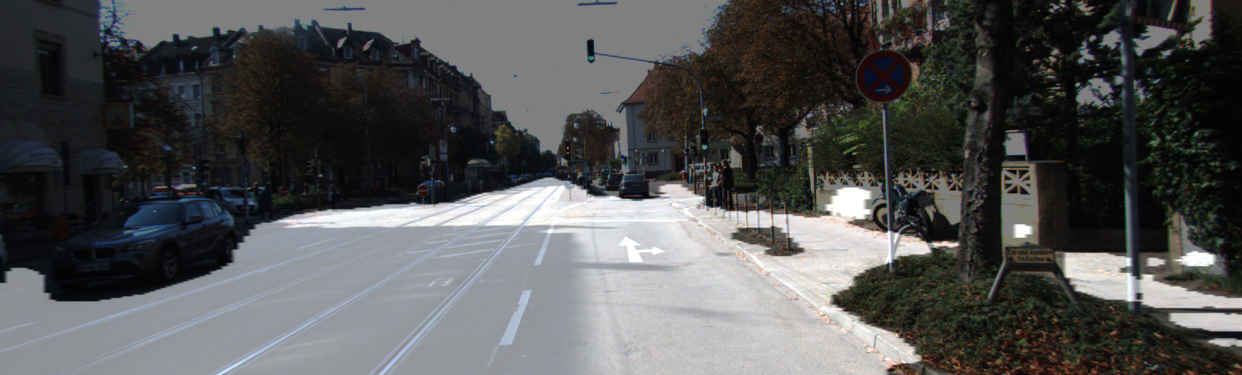

In [27]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
 

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [24]:
# IoU of U-Net

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.813998


0.813997893073479

### S4-2. IoU of of U-Net++

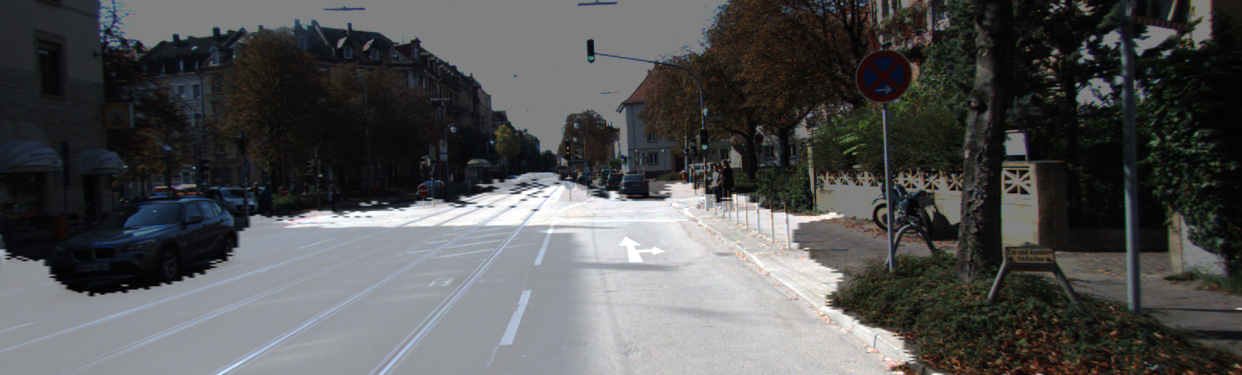

In [28]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model_u_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [25]:
# IoU of U-Net++

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_u_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.880969


0.8809692003390789

## [ 루브릭 ]
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?

* KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한 사이클이 정상 수행되어 세그멘테이션 결과 이미지를 제출함.

2. U-Net++ 모델이 성공적으로 구현되었는가?

* U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상 진행함.

3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교함?

* U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.

  > * IoU of U-Net : 0.813998 <br>
  > * IoU of U-Net++ : 0.880969

## [ 회고 ]

* U-Net++의 개선점에 대한 내용확인은 더 필요하겠지만 U-Net++가 U-Net에 비해 성능이 더 개선된 것은 확인 할 수 있었음.



